# Prediction Of Damages Caused By Floods & Earthqaukes Using ANN

### Abstract

Natural disasters are an increasing phenomenon clearly perceived and known to have a direct, life-altering impact on the welfare of the region it hits and its residents. Depending on where we live, hurricanes, earthquakes, floods, droughts, etc are a threat to lives, properties, productive assets & financial resources. The growing incidence of natural disasters is directly proportional to the increasing vulnerability of households and communities in affected regions. In this work, an artificial neural network has been used to predict the damages caused by natural disasters that can be felt at the community, city and state level as well as on an entire country. Artificial neural networks are mathematical models, inspired by a biological neural network process – the biological neuron. They are used for the modeling of various complex input and output relationships as well as to find and match patterns of any given data. This report results in the comparison of different machine learning algorithms currently used to increase the accuracy of predictions. Training various neural networks, damages occurred due to floods & earthquakes have been estimated using test data.

### Implementation

Natural disasters cause massive casualties, damages and leave many injured. Human beings cannot stop them but timely prediction and due safety measures can prevent loss of human lives and many precious objects can be saved. The main focus of this project is on the application of data-driven models in the context of real-time forecasting of the damages.

This section follows an implementation plan which includes Data Selection, Data Preprocessing and Visualization, Application of Artificial Neural Networks, and its performance evaluation.

#### Importing Packages

In [12]:
# External Packages
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import time
import os

# Visualzation Packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.basemap import Basemap
import squarify
import plotly.plotly as py
import plotly.graph_objs as go
import plotly 
plotly.tools.set_credentials_file(username='psn1997', api_key='ffj08tmHIdZR3dUcbBIv')

# Encoding Packages
import category_encoders as ce  #Category Encoder
from sklearn.preprocessing import LabelEncoder  #Label Encoder

# Preprocessing Packages
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn import svm  #SVM Model
from sklearn.tree import DecisionTreeClassifier  #Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier  #Random Forest Classifier

# Artificial Neural Network Models
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from keras.utils import np_utils
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense  #FFNN
from keras.layers.recurrent import LSTM  #RNN
from keras.layers import Embedding
from keras.optimizers import RMSprop
from rbflayer import RBFLayer, InitCentersRandom  #RBFN 

# Evaluation Packages
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

#### Confusion Matrix Function 

A confusion matrix of size n x n associated with a classifier shows the predicted and actual classification, where n is the number of different classes. The prediction accuracy and classification error can be obtained from this matrix.
This function prints and plots the confusion matrix.

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#### Evaluation Function

**Precision:** What proportion of positive identifications was actually correct.<br> 
**Recall:** What proportion of actual positives was identified correctly.<br>
**F1 Score:** is needed when you want to seek a balance between Precision and Recall.<br>
**Cohen Kappa Score:** Kappa Score is a metric that compares an Observed Accuracy with an Expected Accuracy.<br>

In [14]:
def evaluate_model(y_true, pred):
    class_names = np.array(['1','2','3','4'])
    plot_confusion_matrix(y_test, pred,classes= class_names , title='Confusion matrix, without normalization')
    plt.show()
    print("Cohen Kappa Score: "+ str(cohen_kappa_score(y_test, pred)))
    print("Classification report \n" + str(classification_report(y_test, pred, target_names=class_names)))
    
    return

#### Read Data

National Centers for Environmental Information (formerly NGDC) maintains the data of significant earthquakes. It contains the information on destructive earthquakes from 2150 B.C. to present that meet at least one of the following criteria: Moderate Damage (approximately $1 million or more), 10 or more deaths, magnitude 7.5 or greater, or if earthquake generated a Tsunami.

The portion of the dataset taken into consideration is from the year 1960 till 2019 and contains 2312 rows.

In [15]:
earthquakes = pd.read_csv("database.csv", index_col=None)
np.random.seed(0)

In [16]:
# Parsing Date and Time
earthquakes['DateTime_parsed'] = pd.to_datetime(earthquakes[['Month','Day','Year','Hour','Minute']], format = '%m/%d/%Y %I:%M %p')

#### Visulization of Data

In [17]:
viz_earthquakes = earthquakes.copy()
viz_earthquakes = viz_earthquakes.dropna(subset=["Magnitude"])

Base Map Plot
World Map Damage vs Magnitude

In [18]:
Class = []

for index, row in viz_earthquakes.iterrows():
    if(row["Magnitude"] < 5.0):
        Class.append("Light")
    elif(row["Magnitude"] >= 5.0 and row["Magnitude"] < 7.0):
        Class.append("Strong")
    elif(row["Magnitude"] >= 7.0):
        Class.append("Major")
    else:
        Class.append(np.nan)
        
viz_earthquakes["Class"] = Class

In [19]:
size = []

for index, row in viz_earthquakes.iterrows():
    if(row['Damage'] == 1.0):
        size.append(600)
    elif(row['Damage'] == 2.0):
        size.append(800)
    elif(row['Damage'] == 3.0):
        size.append(900)
    elif(row['Damage'] == 4.0):
        size.append(1500)
    else:
        size.append(0)
        
viz_earthquakes["Size"] = size

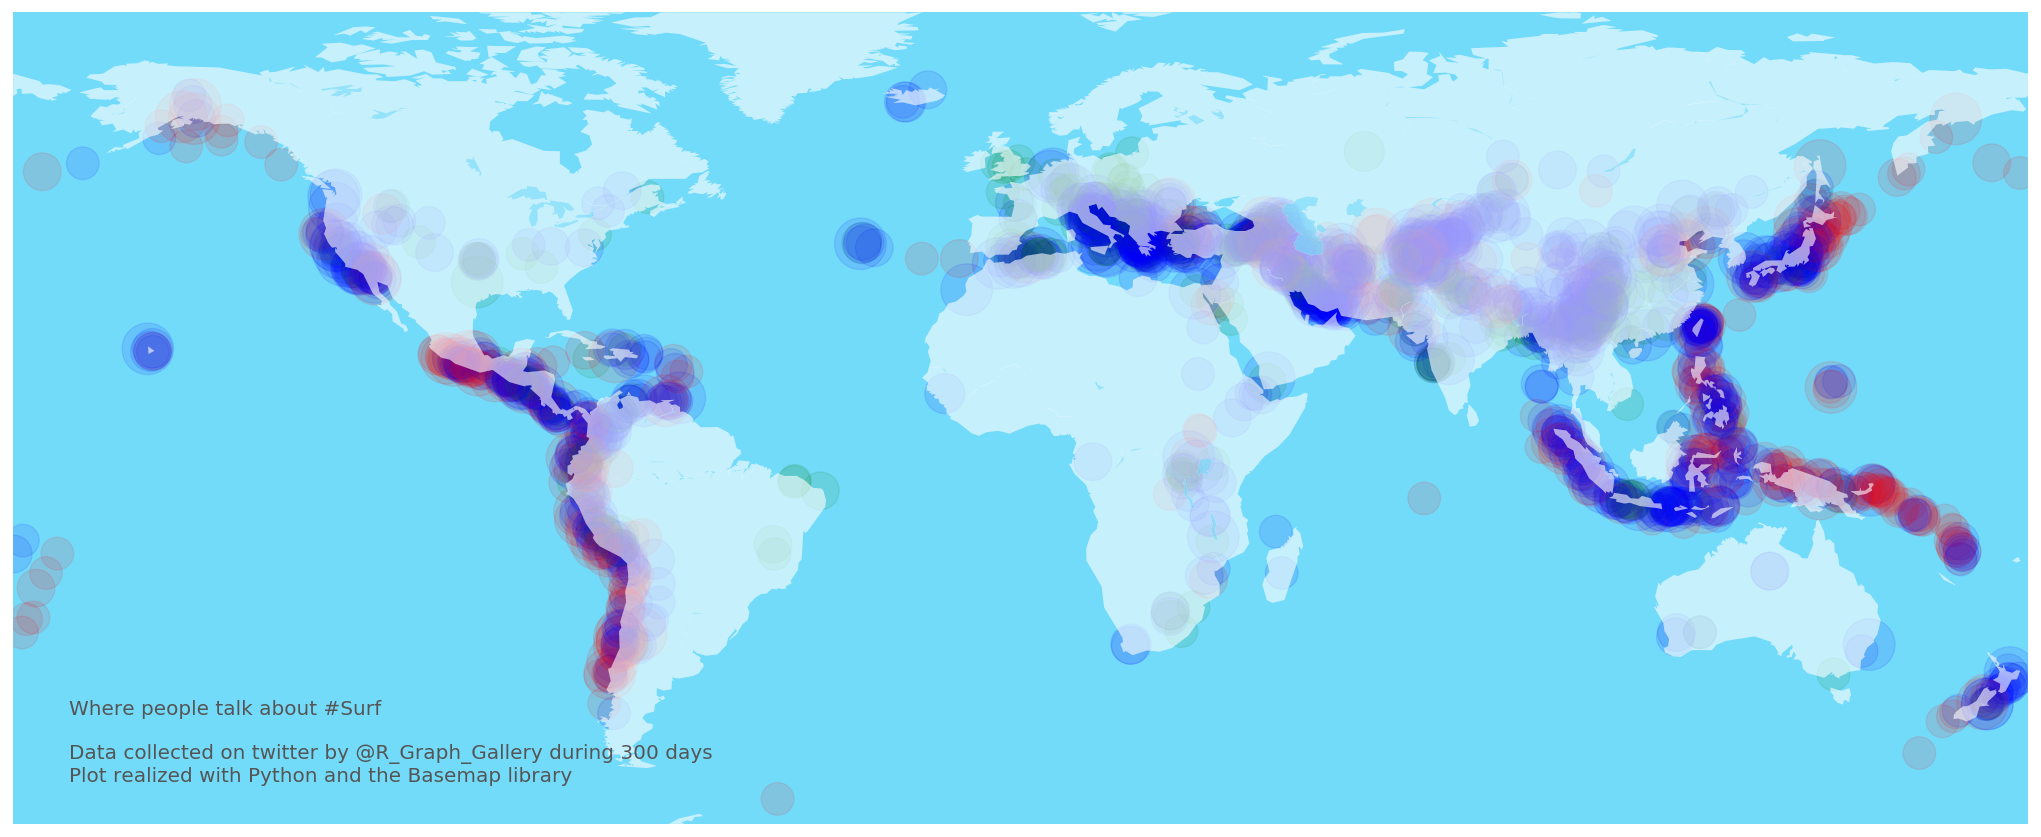

In [9]:
# Set the dimension of the figure
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#73DBFA', linewidth=0)
m.fillcontinents(color='white', alpha=0.6)
m.drawcoastlines(linewidth=0.1, color="white")

# prepare a color for each point depending on the continent.
viz_earthquakes['labels_enc'] = pd.factorize(viz_earthquakes['Class'])[0]
 
# Add a point per position
colors = ['red','blue', 'green']
m.scatter(viz_earthquakes['Longitude'], viz_earthquakes['Latitude'], s=viz_earthquakes['Size'], alpha=0.1, c=viz_earthquakes['labels_enc'], cmap=matplotlib.colors.ListedColormap(colors))

# copyright and source data info
plt.text( -170, -58,'Where people talk about #Surf\n\nData collected on twitter by @R_Graph_Gallery during 300 days\nPlot realized with Python and the Basemap library', ha='left', va='bottom', size=15, color='#555555' )
 
plt.show()

Squarify Plot <br>
Earthquake Prone Countries

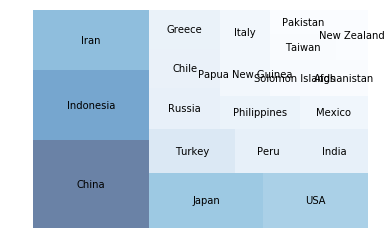

In [10]:
freq_earthquakes = viz_earthquakes['Country'].value_counts()
freq_earthquakes = freq_earthquakes.to_frame().reset_index()
freq_earthquakes = freq_earthquakes.rename(columns= {"index": "Country", "Country":"Frequency"})

cmap = matplotlib.cm.Blues
mini=freq_earthquakes['Frequency'][0:20].min()
maxi=freq_earthquakes['Frequency'][0:20].max()
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in freq_earthquakes['Frequency'][0:20]]

squarify.plot(sizes=freq_earthquakes['Frequency'][0:20], label=freq_earthquakes['Country'][0:20], alpha=.6, color=colors)
plt.axis('off')
plt.show()

Correlation Matrix

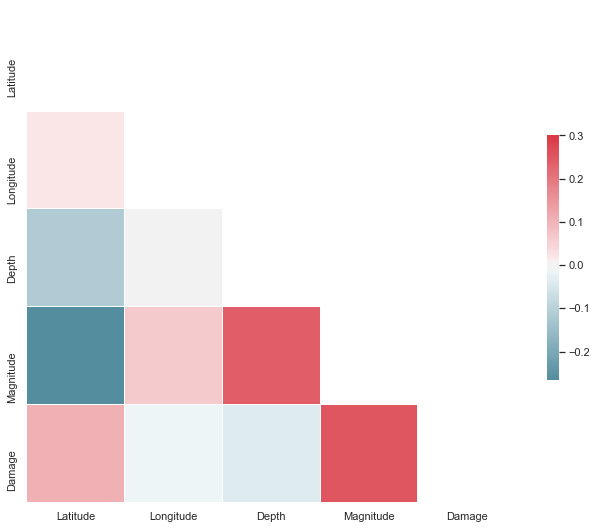

In [11]:
#Plotting a diagonal correlation matrix
corr_earthquakes = viz_earthquakes[['Latitude', 'Longitude', 'Depth', 'Magnitude', 'Damage']].copy()

# Compute the correlation matrix
corr = corr_earthquakes.corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#### Preprocessing of Data
**Discarding Null Values:** Preprocessing on earthquakes dataset involved discarding rows having null values, as these null values are either not supported by many machine learning models or these values caused the output to give a skewed accuracy. <br>
**Scaling of Data:** Dataset comprised of attributes of varying scale and Latitude and Longitude attributes had negative coordinates. A few tree-based algorithms cannot take a negative value as an input hence scaling of these values was essential. It also helped in optimize the machine learning algorithms.

In [20]:
final_earthquakes = earthquakes[['Latitude', 'Longitude', 'Depth', 'Magnitude', 'Damage', 'DateTime_parsed']].copy()
final_earthquakes = final_earthquakes.dropna(subset=["Damage"])
final_earthquakes = final_earthquakes.dropna(subset=["Magnitude"])
final_earthquakes = final_earthquakes.dropna(subset=["Depth"])

In [21]:
final_earthquakes['TimeStamp'] = final_earthquakes['DateTime_parsed'].view('int64')
final_earthquakes = final_earthquakes[['Latitude', 'Longitude', 'Depth', 'Magnitude', 'Damage']].copy()

scaler = MinMaxScaler(feature_range=(0, 10))
svm_earthquakes = final_earthquakes.copy()
svm_earthquakes[['Latitude', 'Longitude']] = scaler.fit_transform(svm_earthquakes[['Latitude', 'Longitude']])
scaler = MinMaxScaler(feature_range=(0, 10))

#### Application of Models

This project elaborates six models, which forms the core of our comprehensive comparative study to predict the possible damages caused due to natural disasters.

**Machine Learning Models**

In [22]:
X = final_earthquakes[['Latitude', 'Longitude', 'Depth', 'Magnitude']].copy()
y = final_earthquakes[['Damage']].copy()

In [23]:
# Split Data into Train & Test Data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train['Damage'].value_counts())
print(y_test['Damage'].value_counts())
print(y_train['Damage'].value_counts(normalize = True))
print(y_test['Damage'].value_counts(normalize = True))

(1482, 4) (371, 4) (1482, 1) (371, 1)
1.0    538
2.0    522
3.0    221
4.0    201
Name: Damage, dtype: int64
1.0    146
2.0    118
3.0     62
4.0     45
Name: Damage, dtype: int64
1.0    0.363023
2.0    0.352227
3.0    0.149123
4.0    0.135628
Name: Damage, dtype: float64
1.0    0.393531
2.0    0.318059
3.0    0.167116
4.0    0.121294
Name: Damage, dtype: float64


**Support Vector Machine (SVM) Model**

0.41778975741239893
Confusion matrix, without normalization


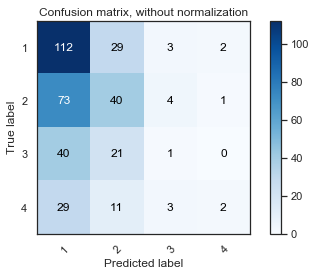

Cohen Kappa Score: 0.08658186294624537
Classification report 
              precision    recall  f1-score   support

           1       0.44      0.77      0.56       146
           2       0.40      0.34      0.37       118
           3       0.09      0.02      0.03        62
           4       0.40      0.04      0.08        45

   micro avg       0.42      0.42      0.42       371
   macro avg       0.33      0.29      0.26       371
weighted avg       0.36      0.42      0.35       371



In [22]:
# Create a SVM Model
clf = svm.SVC(gamma='auto', decision_function_shape='ovo')

# Train the model using the training sets
clf.fit(X_train, y_train.values.ravel())

# Predict the response for test dataset
pred = clf.predict(X_test)

# Print Model Accuracy
print(clf.score(X_test, y_test))

# Evaluate Model
evaluate_model(y_test, pred)

**Decision Tree Classifier**

Accuracy: 0.3908355795148248
Confusion matrix, without normalization


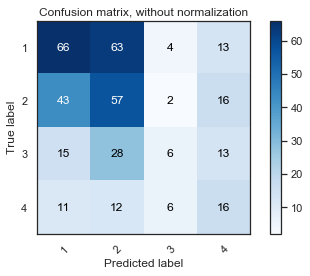

Cohen Kappa Score: 0.12041961709939686
Classification report 
              precision    recall  f1-score   support

           1       0.49      0.45      0.47       146
           2       0.36      0.48      0.41       118
           3       0.33      0.10      0.15        62
           4       0.28      0.36      0.31        45

   micro avg       0.39      0.39      0.39       371
   macro avg       0.36      0.35      0.34       371
weighted avg       0.39      0.39      0.38       371



In [42]:
# Create Decision Tree classifer
clf = DecisionTreeClassifier(criterion="entropy", splitter="best",max_depth=9)

# Train the model using the training sets
clf = clf.fit(X_train,y_train)

# Predict the response for test dataset
pred = clf.predict(X_test)

# Print Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, pred))

# Evaluate Model
evaluate_model(y_test, pred)

**Random Forest Classifier**

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


Accuracy: 0.4528301886792453
Confusion matrix, without normalization


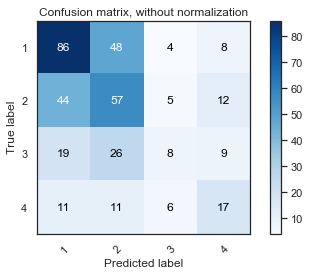

Cohen Kappa Score: 0.19904497548628608
Classification report 
              precision    recall  f1-score   support

           1       0.54      0.59      0.56       146
           2       0.40      0.48      0.44       118
           3       0.35      0.13      0.19        62
           4       0.37      0.38      0.37        45

   micro avg       0.45      0.45      0.45       371
   macro avg       0.41      0.39      0.39       371
weighted avg       0.44      0.45      0.44       371



In [43]:
# Create Random Forest classifer
clf=RandomForestClassifier(n_estimators=200,criterion='entropy',max_depth=30,min_samples_split=10,min_samples_leaf=1, max_features='sqrt',verbose=1)

# Train the model using the training sets
clf.fit(X_train,y_train)

# Predict the response for test dataset
pred=clf.predict(X_test)

# Print Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, pred))

# Evaluate Model
evaluate_model(y_test, pred)

**Artificial Neural Network**

In [16]:
#Covert classes to categorical type

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)

encoded_y_train = np_utils.to_categorical(encoded_Y)

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)

encoded_y_test = np_utils.to_categorical(encoded_Y)

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

**Feed Forward Neural Network**

In [17]:
# Synthetic Minority Over-sampling Technique


smote = SMOTE('minority')

print(X_train.shape)
print(y_train.shape)

sm_X_train, sm_y_train = smote.fit_sample(X_train, y_train)

sm_X_train, sm_y_train = smote.fit_sample(sm_X_train, sm_y_train)

print(sm_X_train.shape)
print(sm_y_train.shape)

print("1.0: " + str(np.count_nonzero(sm_y_train == 1)))
print("2.0: " + str(np.count_nonzero(sm_y_train == 2)))
print("3.0: " + str(np.count_nonzero(sm_y_train == 3)))
print("4.0: " + str(np.count_nonzero(sm_y_train == 4)))

(1482, 4)
(1482, 1)
(2136, 4)
(2136,)
1.0: 538
2.0: 522
3.0: 538
4.0: 538


C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [18]:
# Assigning class weight
a = y_train["Damage"].values
class_weight = class_weight.compute_class_weight('balanced', np.unique(a), a)
print(class_weight)

[0.68866171 0.70977011 1.67647059 1.84328358]


In [19]:
# Create Feed Forward Neural Network
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=4))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile the Network
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Train the model using the training sets
model.fit(X_train, encoded_y_train, batch_size=10, epochs=40, verbose=1, class_weight = class_weight, validation_data=(X_test, encoded_y_test))

# Print Model Accuracy
[test_loss, test_acc] = model.evaluate(X_test,encoded_y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Train on 1482 samples, validate on 371 samples
Epoch 1/40
1482/1482 [==============================] - 3s 2ms/step - loss: 3.4690 - acc: 0.3455 - val_loss: 1.3505 - val_acc: 0.3720
Epoch 2/40
1482/1482 [==============================] - 0s 279us/step - loss: 1.3472 - acc: 0.3684 - val_loss: 1.3131 - val_acc: 0.3477
Epoch 3/40
1482/1482 [==============================] - 0s 275us/step - loss: 1.3172 - acc: 0.3536 - val_loss: 1.3474 - val_acc: 0.3315
Epoch 4/40
1482/1482 [==============================] - 0s 277us/step - loss: 1.2994 - acc: 0.3718 - val_loss: 1.2948 - val_acc: 0.3693
Epoch 5/40
1482/1482 [==============================] - 0s 297us/step - loss: 1.3055 - acc: 0.3596 - val_loss: 1.3178 - val_acc: 0.3666
Epoch 6/40
1482/1482 [==============================] - 0s 294us/step - loss: 1.2979 - acc: 0.3718 - val_loss: 1.3048 - val_acc: 0.3261
Epoch 7/40
1482/1482 [==============================] - 0s 266us/step - loss: 1.2893 - acc: 0.3677 - val_loss: 1.2923 - val_acc: 0.3908
Epo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
None
Confusion matrix, without normalization


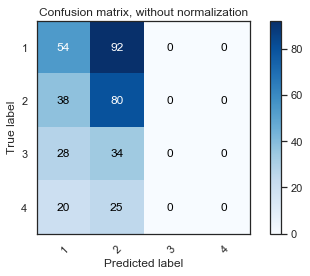

Cohen Kappa Score: 0.02241419565724967
Classification report 
              precision    recall  f1-score   support

           1       0.39      0.37      0.38       146
           2       0.35      0.68      0.46       118
           3       0.00      0.00      0.00        62
           4       0.00      0.00      0.00        45

   micro avg       0.36      0.36      0.36       371
   macro avg       0.18      0.26      0.21       371
weighted avg       0.26      0.36      0.29       371



C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [20]:
# Print Model Summary
print(model.summary())

pred = model.predict_classes(X_test) + 1

# Evaluate Model
evaluate_model(y_test, pred)

In [22]:
#Save model as Json

modelFnn = model.to_json()
with open("modelFNN.json", "w") as json_file:
    json_file.write(modelFnn)
    
model.save_weights("modelFnn.h5")
print("Saved Model to Disk")

Saved Model to Disk


**Recurrent Neural Network**

In [57]:
# Create Recurrent Neural Network
embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2500, embed_dim,input_length = X.shape[1], dropout = 0.2))
model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(4,activation='softmax'))

# Compile the Network
model.compile(loss = 'categorical_crossentropy', optimizer='SGD',metrics = ['accuracy'])

# Train the model using the training sets
model.fit(X_train, encoded_y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, encoded_y_test))

# Print Model Accuracy
[test_loss, test_acc] = model.evaluate(X_test,encoded_y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`



Train on 1482 samples, validate on 371 samples
Epoch 1/20
1482/1482 [==============================] - 4s 3ms/step - loss: 1.3377 - acc: 0.3576 - val_loss: 1.3123 - val_acc: 0.3181
Epoch 2/20
1482/1482 [==============================] - 2s 2ms/step - loss: 1.2995 - acc: 0.3516 - val_loss: 1.2998 - val_acc: 0.3181
Epoch 3/20
1482/1482 [==============================] - 2s 2ms/step - loss: 1.2928 - acc: 0.3576 - val_loss: 1.2965 - val_acc: 0.3181
Epoch 4/20
1482/1482 [==============================] - 2s 2ms/step - loss: 1.2909 - acc: 0.3657 - val_loss: 1.2937 - val_acc: 0.3962
Epoch 5/20
1482/1482 [==============================] - 2s 2ms/step - loss: 1.2903 - acc: 0.3603 - val_loss: 1.2918 - val_acc: 0.3935
Epoch 6/20
1482/1482 [==============================] - 2s 2ms/step - loss: 1.2898 - acc: 0.3664 - val_loss: 1.2928 - val_acc: 0.3639
Epoch 7/20
1482/1482 [==============================] - 2s 2ms/step - loss: 1.2899 - acc: 0.3576 - val_loss: 1.2904 - val_acc: 0.3935
Epoch 8/20
1482

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4, 128)            320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_16 (Dense)             (None, 16)                3216      
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 68        
Total params: 586,484
Trainable params: 586,484
Non-trainable params: 0
_________________________________________________________________
None
Confusion matrix, without normalization


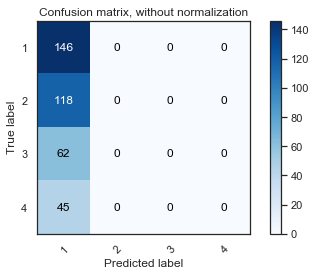

Cohen Kappa Score: 0.0
Classification report 
              precision    recall  f1-score   support

           1       0.39      1.00      0.56       146
           2       0.00      0.00      0.00       118
           3       0.00      0.00      0.00        62
           4       0.00      0.00      0.00        45

   micro avg       0.39      0.39      0.39       371
   macro avg       0.10      0.25      0.14       371
weighted avg       0.15      0.39      0.22       371



C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [58]:
# Print Model Summary
print(model.summary())

pred = model.predict_classes(X_test)+1

# Evaluate Model
evaluate_model(y_test, pred)

**Radial Basis Function Network**

In [59]:
# Create Radial Basis Function Network
if __name__ == "__main__":

    X=X_train.values
    y=encoded_y_train

    model = Sequential()
    rbflayer = RBFLayer(16,
                        initializer=InitCentersRandom(X), 
                        betas=1.0,
                        input_shape=(4,))
    model.add(rbflayer)
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))

# Compile the Network
    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(), metrics=['accuracy'])

# Train the model using the training sets
    model.fit(X, y,
              batch_size=10,
              epochs=20,
              verbose=1)

# Print Model Accuracy
test_X=X_test.values
test_Y=encoded_y_test
[test_loss, test_acc] = model.evaluate(test_X,test_Y)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Epoch 1/20
1482/1482 [==============================] - 1s 927us/step - loss: 0.1840 - acc: 0.3691
Epoch 2/20
1482/1482 [==============================] - 1s 339us/step - loss: 0.1790 - acc: 0.3617
Epoch 3/20
1482/1482 [==============================] - 1s 349us/step - loss: 0.1766 - acc: 0.3603
Epoch 4/20
1482/1482 [==============================] - 0s 337us/step - loss: 0.1761 - acc: 0.3617
Epoch 5/20
1482/1482 [==============================] - 1s 353us/step - loss: 0.1760 - acc: 0.3623
Epoch 6/20
1482/1482 [==============================] - 1s 342us/step - loss: 0.1759 - acc: 0.3441
Epoch 7/20
1482/1482 [==============================] - 1s 355us/step - loss: 0.1759 - acc: 0.3623
Epoch 8/20
1482/1482 [==============================] - 1s 343us/step - loss: 0.1759 - acc: 0.3596
Epoch 9/20
1482/1482 [==============================] - 1s 353us/step - loss: 0.1759 - acc: 0.3549
Epoch 10/20
1482/1482 [==============================] - 1s 408us/step - loss: 0.1759 - acc: 0.3549
Epoch 11/

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_2 (RBFLayer)       (None, 16)                80        
_________________________________________________________________
dense_18 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 68        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
None
Confusion matrix, without normalization


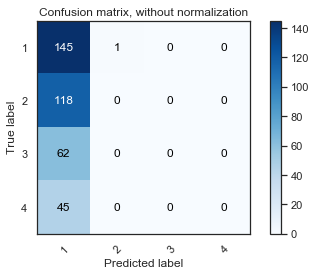

Cohen Kappa Score: -0.004107636851370389
Classification report 
              precision    recall  f1-score   support

           1       0.39      0.99      0.56       146
           2       0.00      0.00      0.00       118
           3       0.00      0.00      0.00        62
           4       0.00      0.00      0.00        45

   micro avg       0.39      0.39      0.39       371
   macro avg       0.10      0.25      0.14       371
weighted avg       0.15      0.39      0.22       371



C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Danesh Parwani\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [63]:
# Print Model Summary
print(model.summary())

pred = model.predict_classes(X_test)+1

# Evaluate Model
evaluate_model(y_test, pred)

### Test with your own inputs

In [24]:
json_file = open('modelFNN.json',  'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("modelFnn.h5")
print("Loaded model from Disk")

Loaded model from Disk


In [25]:
print(X_test.head(5))

      Latitude  Longitude  Depth  Magnitude
930     43.853     16.633   24.0        5.6
1229    63.966    -20.487   10.0        6.5
1783    25.280     95.101   82.0        5.2
1895    43.015     88.247   21.0        5.3
55      43.300     17.100   33.0        5.9


In [26]:
lat = input("Enter Latitude: ")
long = input("Enter Longitude: ")
depth = input("Enter Depth: ")
mag = input("Enter Magnitude: ")

test = pd.DataFrame(columns=['Latitude', 'Longitude', 'Depth', 'Magnitude'])

test = test.append({'Latitude': lat , 'Longitude': long, 'Depth': depth, 'Magnitude': mag} , ignore_index=True)

Enter Latitude: 1
Enter Longitude: 0
Enter Depth: 0
Enter Magnitude: 0


In [27]:
pred = loaded_model.predict_classes(test)+1

print("Predicted Damage is: " +str(pred))

InternalError: Blas GEMM launch failed : a.shape=(1, 4), b.shape=(4, 16), m=1, n=16, k=4
	 [[Node: dense_1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_dense_1_input_0_0/_37, dense_1/kernel/read)]]
	 [[Node: dense_3/Softmax/_39 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_32_dense_3/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]